## Exploration 08

## 1. 데이터 준비

In [28]:
import nltk # NLTK 패키지에서 불용어 사전 다운로드
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
import urllib.request # urllib을 이용하여 뉴스 기사 데이터를 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [30]:
data.sample(10) # headlines와 text로 이루어져 있는 데이터임을 확인하기 위함

,headlines,text
20241,JNU to rename new management school after late...,JNU has proposed to rename its School of Manag...
96990,FreeCharge pulls out of IPL contract following...,Snapdeal-owned FreeCharge has pulled out from ...
93334,French judges ask EU Parliament to lift Le Pen...,French judges have asked the European Parliame...
63724,"Man reselling his iPhone X pre-order for $60,0...",A user on eBay has put up his iPhone X pre-ord...
41134,"Israel, UN reach deal to settle African migran...",Israel has reached a deal with the UN to settl...
6113,Our government has kept inflation on a tight l...,"PM Narendra Modi, while interacting with booth..."
38018,RJD leaders booked for forcing gangrape victim...,Seven members of the Rashtriya Janata Dal part...
53116,Nokia unveils sleep tracker to monitor user's ...,Nokia has unveiled a sleep tracking system cal...
81080,Gurugram museum to showcase an antique Kolkata...,The Heritage Transport Museum in Gurugram will...
5551,"India will need 2,300 planes worth $320 billio...","India will need 2,300 airplanes worth $320 bil..."


## 2. 데이터 전처리

* headlines는 text의 요약이므로, 동일한 요약들이 존재할 수 있으나, text 자체가 중복이 된 경우는 중복 샘플이므로 제거해야 한다.

In [31]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [32]:
# text의 중복 샘플을 drop_duplicates()를 이용하여 제거
data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플 수 :',(len(data)))

전체 샘플 수 : 98360


In [33]:
# 데이터 프레임에 NULL값 있는지 확인
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [34]:
# text 정규화를 위한 사전을 구성하는 과정
# text normalization : 같은 의미이지만 다른 표현으로 사용되는 단어들을 같은 단어로 통일시켜주는 역할

contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [35]:
"""NLTK에서 제공하는 불용어 리스트를 참조하여, 
샘플에서 불용어를 제거해야 하는데,
먼저 그 전에 몇 개의 불용어가 있는지 확인하는 과정"""

print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [36]:
def preprocess_sentence(sentence, remove_stopwords=True): # preprocess_sentence(): 텍스트 전처리 함수
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [37]:
clean_text = [] # 전체 text에 대하여 전처리 과정을 거침

for s in data['text']: #전처리 과정을 거친 text 데이터는 clean_text라는 빈 리스트에 추가
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [38]:
#이제 headlines에 대해서 전처리 함수를 호출해 줄 때는, 불용어 제거를 수행하지 않는다는 의미에서 두 번째 인자로 False를 넣는다.
clean_headlines = []

# 전체 headlines 데이터에 대한 전처리
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False)) # 불용어를 제거하지 않습니다.

clean_headlines[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [39]:
# dataframe의 text와 headlines 열의 데이터들을 전처리 과정을 거친 clean_text와 clean_headlines 데이터로 바꿈
data['text'] = clean_text
data['headlines'] = clean_headlines

# dataframe에 빈 문자열이 존재하는 경우, NULL 값으로 변환
data.replace('', np.nan, inplace=True)

In [40]:
# dataframe 내에 NULL 값이 존재하는지 확인
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [41]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


## 3. 훈련 데이터와 테스트 데이터 분리

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


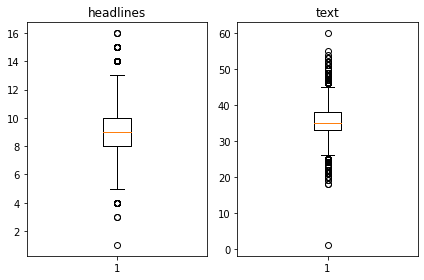

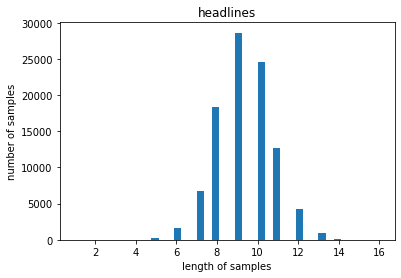

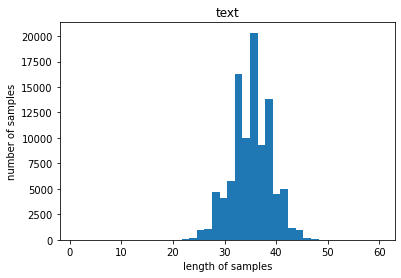

In [42]:
"""
* text와 headlines의 최소, 최대, 평균 길이를 확인하고 길이 분포를 시각화
* text의 경우, 최소 길이와 최대 길이의 차이가 크지만, 대체적으로 25 ~ 45 사이의 길이를 갖는다는 것을 그래프를 통해 확인
* headlines의 경우, 최소 길이와 최대 길이의 차이가 크지 않고, text에 비해 길이가 상대적으로 짧음
"""

import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [43]:
# text와 headlines의 적절한 최대 길이를 임의로 설정
text_max_len = 45
headlines_max_len = 13

In [44]:
# 이전에 정한 최대 길이를 기준에 포함되는 text와 headlines의 비율을 계산하는 함수

def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [45]:
# text와 headlines의 약 99% 이상의 데이터들이 포함되는 것을 확인
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len, data['headlines'])

전체 샘플 중 길이가 45 이하인 샘플의 비율: 0.9967771451809678
전체 샘플 중 길이가 13 이하인 샘플의 비율: 0.9981699877999186


In [46]:
"""이전에 설정한 최대 길이보다 짧은 text, headlines만 dataframe에 남겨놓음(설정한 최대 길이보다 긴 데이터들은 dataframe에서 제외)"""
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플 수 :',(len(data))) # 최종적으로 남는 샘플의 수는 97,863개

전체 샘플 수 : 97863


In [47]:
"""요약 데이터에 시작 토큰과 종료 토큰을 추가
:디코더에서 시작 토큰을 입력받아 문장을 생성하기 시작하고, 
종료 토큰을 예측하는 순간 문장 생성을 멈춤"""

data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [48]:
# 인코더의 입력, 디코더의 입력, 디코더의 레이블을 numpy 타입으로 dataframe에 저장

encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [49]:
"""훈련 데이터와 테스트 데이터를 분리하기 전에, 
encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 선언"""

indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[61184 48725  3978 ... 52968 80020 17107]


In [50]:
"""앞서 만든 정수 시퀀스를 이용하여, 데이터의 샘플 순서를 정의.
샘플을 섞어주는 역할을 수행함."""

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [51]:
"""섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리하기 위함.
전체 데이터 크기에 0.2를 곱하여, 테스트 데이터의 크기를 정의"""

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 19572


In [52]:
"""앞서 정의한 테스트 데이터의 갯수를 이용하여 
전체 데이터를 훈련 데이터와 테스트 데이터로 분리함."""

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :',len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 78291
훈련 레이블의 개수 : 78291
테스트 데이터의 개수 : 19572
테스트 레이블의 개수 : 19572


## 4. 정수 인코딩

In [53]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [54]:
"""등장 빈도가 threshold 보다 작은 단어들은 정수 인코딩 과정에서 제외하고, 
훈련 데이터에서 제거하기 위한 과정

전체 단어의 빈도수 총합과 
threshold보다 빈도수가 작은 단어의 등장 빈도수의 총합을 출력"""

threshold = 7 # 빈도수 : threshold를 설정하여, 등장 빈도가 7회 미만인 단어들의 갯수를 카운트
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69205
등장 빈도가 6번 이하인 희귀 단어의 수: 47077
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22128
단어 집합에서 희귀 단어의 비율: 68.02543168846181
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.4827820585764795


threshold 보다 빈도수가 적은 단어의 갯수는 47,107개로 약 68%

In [55]:
"""등장 빈도가 threshold 보다 적은 단어들을 제외한 단어 집합의 크기가 22,065개 이므로, 
단어 집합의 크기를 20,000으로 설정"""

src_vocab = 20000
src_tokenizer = Tokenizer(num_words = src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합의 크기를 이용하여, 단어 집합을 재생성

In [56]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[5519, 56, 551, 1089, 419, 854, 653, 942, 169, 12857, 157, 8, 86, 323, 3777, 5, 21, 423, 4297, 4095, 1, 101, 125, 551, 1089, 5266, 9791, 120, 743, 306, 5, 5464, 1, 7779, 4369, 541, 12146, 226], [12, 1644, 37, 92, 1291, 18, 4820, 2948, 5684, 37, 1007, 1798, 213, 84, 786, 22, 563, 4820, 1291, 196, 12, 37, 4820, 183, 18, 1979], [1402, 390, 2, 3170, 521, 1547, 107, 10942, 5639, 13685, 707, 6216, 171, 5009, 6933, 13686, 629, 1629, 226, 425, 124, 7323, 721, 705, 2302, 237, 2007, 385, 1098, 10662, 1, 615, 7204, 3836, 3529, 1037, 10662, 4]]


In [57]:
"""keras의 토크나이저를 이용하여, 
decoder_input에 대해서도 encoder_input과 똑같은 작업을 수행"""

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [58]:
# 데이터 내 각 단어의 등장 빈도수를 확인하는 과정.

threshold = 6
total_cnt = len(tar_tokenizer.word_index) # threshold를 설정하여, 등장 빈도가 6회 미만인 단어들의 갯수를 카운트
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

# 등장 빈도가 threshold 보다 작은 단어들은 정수 인코딩 과정에서 제외하고, 훈련 데이터에서 제거

단어 집합(vocabulary)의 크기 : 30013
등장 빈도가 5번 이하인 희귀 단어의 수: 19635
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10378
단어 집합에서 희귀 단어의 비율: 65.42165061806551
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.6725512917484835


In [59]:
"""등장 빈도가 threshold 보다 적은 단어들을 제외한 단어 집합의 크기가 10000여개 이므로, 
단어 집합의 크기를 10,000으로 설정

단어 집합의 크기를 이용하여, 단어 집합을 재생성"""
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 샘플을 출력하여 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 245, 1084, 549, 6, 1317, 13], [1, 30, 20, 158, 2613, 6, 14, 33, 4, 4000, 8764], [1, 4824, 1390, 8765, 5407, 3790, 7, 338, 1019, 222], [1, 6181, 1585, 1100, 1048, 285], [1, 2382, 15, 8159, 6, 3096, 6, 9529, 4, 4668]]
target
decoder  [[245, 1084, 549, 6, 1317, 13, 2], [30, 20, 158, 2613, 6, 14, 33, 4, 4000, 8764, 2], [4824, 1390, 8765, 5407, 3790, 7, 338, 1019, 222, 2], [6181, 1585, 1100, 1048, 285, 2], [2382, 15, 8159, 6, 3096, 6, 9529, 4, 4668, 2]]


In [33]:
# 요약문의 길이가 1인 경우 삭제

drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :',len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78290
훈련 레이블의 개수 : 78290
테스트 데이터의 개수 : 19572
테스트 레이블의 개수 : 19572


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [60]:
"""서로 다른 길이의 샘플들을 병렬 처리하기 위해서, 
패딩을 이용하여 같은 길이로 맞춰주는 작업을 진행"""

encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headlines_max_len, padding='post')

## 5. 모델 설계하기

In [61]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1 (3개의 층으로 구성)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# 인코더의 최종 출력 벡터는 디코더로 보냄.

In [62]:
"""디코더의 임베딩 층을 설계하는 것은 인코더와 동일
LSTM 층은 initial_state의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어줌"""

# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [65]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

## 6. 모델 훈련하기

In [66]:
# 설계한 model을 훈련/ 최종적으로, model이 최적점에서 훈련을 종료하는 역할을 수행.

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', patience = 2, verbose=1)

# early stopping 기능을 이용하여, 
# validation loss가 증가하는 현상이 2회 관측될 시, 학습을 종료

history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 512, callbacks=[es], epochs = 50)

Epoch 1/50
153/153 [==============================] - 114s 685ms/step - loss: 5.4320 - val_loss: 5.0595
Epoch 2/50
153/153 [==============================] - 104s 683ms/step - loss: 4.8986 - val_loss: 4.6939
Epoch 3/50
153/153 [==============================] - 105s 687ms/step - loss: 4.6085 - val_loss: 4.4662
Epoch 4/50
153/153 [==============================] - 105s 688ms/step - loss: 4.3695 - val_loss: 4.2869
Epoch 5/50
153/153 [==============================] - 105s 689ms/step - loss: 4.1549 - val_loss: 4.1141
Epoch 6/50
153/153 [==============================] - 104s 677ms/step - loss: 3.9768 - val_loss: 3.9905
Epoch 7/50
153/153 [==============================] - 103s 676ms/step - loss: 3.8283 - val_loss: 3.8904
Epoch 8/50
153/153 [==============================] - 103s 675ms/step - loss: 3.6990 - val_loss: 3.8049
Epoch 9/50
153/153 [==============================] - 103s 672ms/step - loss: 3.5841 - val_loss: 3.7383
Epoch 10/50
153/153 [==============================] - 102s 669m

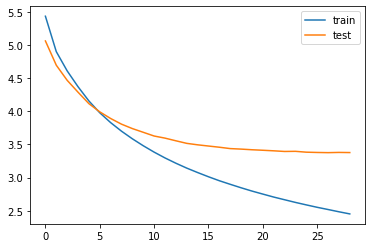

In [67]:
# 훈련 데이터와 테스트 데이터의 loss를 시각화

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

* model의 loss와 validation loss 둘 사이의 격차가 큼
* 훈련 데이터와 테스트 데이터 loss의 격차를 보면, 훈련 데이터가 overfitting이 되었다고 판단할 수 있음

## 7. 모델 테스트하기

In [68]:
# 정수 인덱스 행렬로 존재하는 텍스트 데이터를 실제 데이터로 복원할때 사용할 3개의 사전을 준비

src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [69]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

* 훈련과 달리 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복적으로 동작해야함
* 따라서 인퍼런스를 위한 모델을 별도로 설계
* 이때는, 인코더 모델과 디코더 모델을 분리하여 설계해야함

In [70]:
# 어텐션 함수를 사용하는 출력층을 설계
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])


In [71]:
# 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken' or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [72]:
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

* text의 경우, 패딩을 위해 사용한 숫자 0을 제외
* headlines의 경우, 숫자 0, 시작 토큰, 종료 토큰의 인덱스를 출력에서 제외

In [73]:
for i in range(10):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : hewlett packard enterprise ceo meg whitman stepped chairman board member hp chip ceo levi strauss take chairman hp hewlett packard split two companies hewlett packard enterprise hp whitman exit comes amid reports shortlisted uber ceo post 
실제 요약 : hp ceo steps down from hp board 
예측 요약 :  intel ceo paul quits after years


원문 : north korea tuesday called us nuclear criminal said dismantle arsenal nations step towards nuclear weapons free world accused us wild ambition dominate world nuclear upper hand comes us president donald trump called country nuclear arsenal 
실제 요약 : north korea calls us nuclear criminal 
예측 요약 :  korea korea to hold its third ever north korea


원문 : least students two died fire religious school kuala lumpur today broke bedrooms students could escape due window fires unregistered private religious schools since one considered one malaysia worst fire disasters years 
실제 요약 : students killed in fire at malaysian school 
예측 요약 :  kids die after eating children a

* 10개의 샘플을 출력하여, 실제 headlines와 예측된 headlines를 비교
    + 일부 샘플에서 실제 headlines와 비슷한 headlines를 예측
    + 실제 headlines에서는 사용하지 않은 단어를 이용하여 예측한 headlines도 존재
    + 일부 샘플에 대해서 좋지 않은 예측을 보이는 샘플도 존재

* 따라서, 모델의 성능 개선이 필요

## 8. 추출적 요약

In [74]:
import requests
from summa.summarizer import summarize

In [75]:
text= pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

text.sample(10)

,headlines,text
44528,Deepika features in VarietyÃ¢ÂÂs Int'l Women...,Deepika Padukone is the only Indian actress to...
85722,Will take Ã¢ÂÂ¹5k from SRK for Jab Harry Met ...,Actor Ranbir Kapoor joked that he'll go to act...
93837,Parrikar inducts two former Congressmen into G...,Goa Chief Minister Manohar Parrikar on Wednesd...
41111,CBSE uses encrypted question paper to tackle p...,"In an attempt to tackle paper leaks, the CBSE ..."
4730,18 bikes set on fire in Thane in second such i...,As many as 18 motorcycles were set ablaze at P...
3475,NGT imposes Ã¢ÂÂ¹100 cr fine on Meghalaya ove...,The National Green Tribunal (NGT) on Friday im...
60087,Swaraj tweets ICJ poll result with Vande Matar...,"External Affairs Minister Sushma Swaraj, annou..."
67785,No plans to scrap GE locomotive plant: Piyush ...,Railway Minister Piyush Goyal has said the wor...
78551,"Argument between pilot, flight attendant delay...",An argument between a pilot and a flight atten...
19754,248 party workers died of shock on Karunanidhi...,The DMK on Tuesday said that as many as 248 pa...


In [76]:
for i in range(0, 50, 10):
    print("원문 :", text['text'][i])
    print("실제 요약 :", text['headlines'][i])
    print("추출 요약 :", summarize(text["text"][i], ratio=0.4))
    print("\n")

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
추출 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : Two minor cousins in Uttar Pradesh's Gorakhpur were allegedly repeatedly burnt with tongs and forced to eat human excreta by their family for being friends with two boys from the same school. The cousins revealed their ordeal to the police and Child Welfare Committee after being brought back to Gorakhpur from Nepal, where they had fled to escape the torture.
실제 요약 : UP cousins fed human excreta for friendship with boys
추출 요약 : 


원문 : Claiming there is a dearth of i

## 회고

이번 과제는 각 코드가 어떤 역할을 하는지 파악하는 것에 중점을 두었습니다.
NLP에 대해 아직 다 이해하지 못해서 순서대로 이번 과제를 위해 있어야 하는 코드에 대해서만 인지하고 제출하겠습니다.
